# Atoti Value-at-Risk Benchmark

This notebook is a benchmark template used to expose Atoti performances over ClickHouse by reproducing a benchmark detailed in a [blog post by Altinity on calculating Value-at-Risk (VaR)](https://altinity.com/blog/clickhouse-vs-redshift-performance-for-fintech-risk-management). Check out the [full article](https://www.activeviam.com/blog/atoti-for-risk-management-aggregation-comparison-with-the-clickhouse-benchmark/).

  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=var-benchmark" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Atoti" /></a></div>

In [1]:
import time
import atoti
import pandas as pd

pd.set_option("display.max_columns", 500)

In [2]:
session = atoti.Session.start(
    atoti.SessionConfig(java_options=["-XX:MaxDirectMemorySize=12G"])
)

In [3]:
# Load risk dataset
dataset = session.read_parquet(
    "s3://data.atoti.io/notebooks/var-benchmark/data/dataset.parquet",
    table_name="Dataset",
    partitioning="hash32(str0)",
    default_values={
        "int10": 0,
        "int11": 0,
        "int12": 0,
        "int13": 0,
        "dttime10": 0,
        "dttime11": 0,
        "dttime12": 0,
        "dttime13": 0,
    },
)

In [4]:
dataset.head()

,index,int0,int1,int2,int3,int4,int5,int6,int7,int8,int9,int10,int11,int12,int13,int14,int15,int16,int17,int18,int19,int20,int21,int22,int23,int24,int25,int26,int27,int28,int29,int30,int31,int32,int33,dttime0,dttime1,dttime2,dttime3,dttime4,dttime5,dttime6,dttime7,dttime8,dttime9,dttime10,dttime11,dttime12,dttime13,dttime14,dttime15,dttime16,dttime17,dttime18,dttime19,dttime20,dttime21,dttime22,dttime23,dttime24,dttime25,dttime26,dttime27,dttime28,dttime29,dttime30,dttime31,dttime32,str0,str1,str2,str3,str4,str5,str6,str7,str8,str9,str10,str11,str12,str13,str14,str15,str16,str17,str18,str19,str20,str21,str22,str23,str24,str25,str26,str27,str28,str29,str30,str31,str32,arrFloat,partition
0,34,-583478,796107,-990641,62216,-207047,-59186,320116,-550428,475712,129153,292574,-593941,475712,796107,178893,609814,314638,314638,-550428,129153,989562,810688,-467426,-99861,420514,-647107,178893,673660,490474,917999,319472,-173435,-161629,-461888,1819695640000000000,1906208677000000000,2046567575000000000,2482224572000000000,1673775301000000000,2141994906000000000,1825084354000000000,2242687080000000000,2455198424000000000,2133197985000000000,1736276949000000000,1910081864000000000,1863829144000000000,2142252127000000000,1971720187000000000,2434924170000000000,2209777017000000000,1942410763000000000,2370312544000000000,2519968547000000000,2212666626000000000,1928836868000000000,1945236000000000000,2200535417000000000,1673775301000000000,1932493004000000000,2371521773000000000,1686896824000000000,1550479387000000000,2046567575000000000,1673775301000000000,1786285469000000000,1786285469000000000,YOeccFqbHQKKn,NOnJECHqdZJafUzT,YmcYzCxWmDw,YiyZsVRZhH,UetzvtAg,TVuucHjqMYjyLsT,UuTemKopZjZI,tJAVjLBtOwfpCO,nNjgmDyxIjgMFj,jtgUe,sxAQciMbzeSeiA,NiOug,qtXAyZy,PRBjCTjHuin,lCwYyBZFy,CffuGFgtJsThJv,AssHiKHO,xOHdyAaA,ofXOXGSHA,ofXOXGSHA,gEXjbcM,INoav,nXdYRkkvHqhM,iWgNZqITZM,MPmtrSlg,CQlaERAKGtPwyQqjJSa,TVuucHjqMYjyLsT,qtXAyZy,CgVqw,RzTHrHZpnRLA,gBDTvykvA,DVfvVcIripWEw,zqnPcZ,"[230918.81, 283451.5, 243109.5, 136306.62, 330...",0
1,85,796107,259689,85649,113146,672802,-207047,666654,-891899,139504,178893,-497521,-467426,-891899,-583478,62216,-227342,-604366,-891517,38359,545390,420514,-891899,810688,-215760,-658155,531028,-604366,178893,403368,-63768,475712,-687232,531028,517543,2434924170000000000,2390459607000000000,2142252127000000000,2361411854000000000,1677934919000000000,1906208677000000000,1894719440000000000,2341681689000000000,2242687080000000000,1686896824000000000,1956559567000000000,1788774349000000000,2025043684000000000,1559178750000000000,2141994906000000000,1737313921000000000,1718504956000000000,2288097597000000000,1786285469000000000,1911507622000000000,2046567575000000000,1677934919000000000,1911507622000000000,2096621494000000000,1718504956000000000,2025043684000000000,2434924170000000000,2202704909000000000,2434924170000000000,2439970414000000000,2011089363000000000,1971720187000000000,1686896824000000000,YQOaNFvp,sWRmMfceYqtIvhHpWke,feZfmVod,HeRfRVQza,PRBjCTjHuin,lCwYyBZFy,PdCtjVFdNnbwEza,crkjLsxzJishE,PdCtjVFdNnbwEza,nXdYRkkvHqhM,EzOfb,xOHdyAaA,TZEeZfHce,DNOvPhRTNs,iWgNZqITZM,YmcYzCxWmDw,NhFLOvmpbUrhT,CQlaERAKGtPwyQqjJSa,ofXOXGSHA,czSKAXQTckCeqSkCHF,nRqJuxKcVSMPFTPDOBx,CgVqw,ssJOul,GthjBK,jFMTfRSjZwAcNDyDd,WzrObhrQcaqzHLTz,anQRUhVasxSbMoj,yagzJHsCFYLTRnBfxoq,YQOaNFvp,SJPwm,DxGyHGcK,DNOvPhRTNs,LrCFQPSYwfu,"[49520.383, 151352.4, 473472.4, 163251.27, 926...",0
2,162,-181783,654621,234801,259508,490474,-920096,178893,933619,-59186,-975223,-625869,-975223,234801,609814,314638,403368,796107,810688,85649,-147059,-138909,292574,933619,-467426,-891517,-658155,-782544,-891899,-990641,-99861,-147059,513123,-975223,-625869,1910081864000000000,1956559567000000000,2156640381000000000,2472893108000000000,2442797855000000000,1825084354000000000,1788774349000000000,2496469443000000000,2341681689000000000,2465080786000000000,1686896824000000000,1686896824000000000,1659183478000000000,2121488643000000000,2399887293000000000,1587881046000000000,192883686

In [5]:
cube = session.create_cube(dataset)

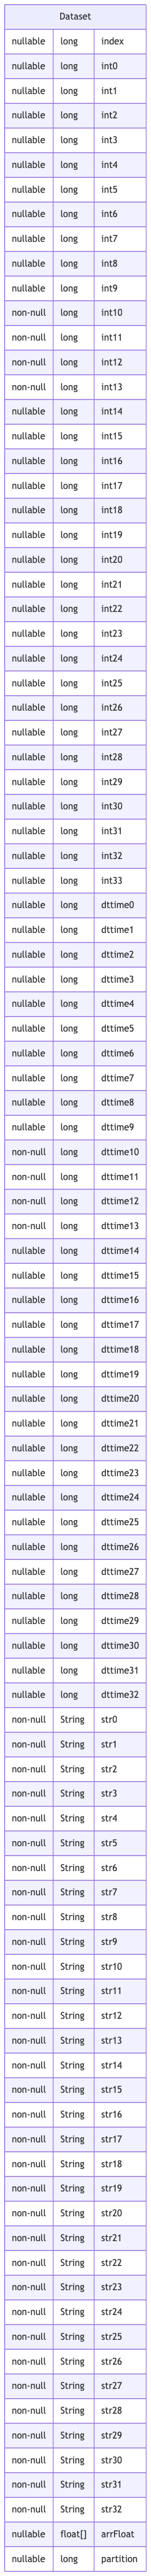

In [6]:
session.tables.schema

In [7]:
# Disable the aggregate cache
cube.aggregate_cache = atoti.AggregateCache(
    capacity=0,
)

In [8]:
# Define vector aggregation and value at risk
h, m, l = cube.hierarchies, cube.measures, cube.levels

m["PnlVector"] = atoti.agg.sum(dataset["arrFloat"])
m["ValueAtRisk"] = atoti.array.quantile(m["PnlVector"], q=0.95)

In [9]:
# Create a hierarchy to access vector elements
cube.create_parameter_hierarchy_from_members("Scenarios", list(range(0, 1000)))
m["PnL at index"] = m["PnlVector"][l["Scenarios"]]

Creating hierarchies for numerical columns required for querying.

In [10]:
h["int10"] = [dataset["int10"]]
h["int11"] = [dataset["int11"]]
h["int12"] = [dataset["int12"]]
h["int13"] = [dataset["int13"]]
h["dttime10"] = [dataset["dttime10"]]
h["dttime11"] = [dataset["dttime11"]]
h["dttime12"] = [dataset["dttime12"]]
h["dttime13"] = [dataset["dttime13"]]

In [11]:
session.link

http://localhost:63025

In [12]:
# Number of facts in the cube
cube.query(m["contributors.COUNT"])

,contributors.COUNT
0,"1,720,000"


### Query Benchmark

In [13]:
def Q1():
    return cube.query(m["ValueAtRisk"], levels=[l["str0"]], mode="raw")


def Q2():
    return cube.query(
        m["ValueAtRisk"],
        levels=[
            l["str0"],
            l["str1"],
            l["int10"],
            l["int11"],
            l["dttime10"],
            l["dttime11"],
        ],
        mode="raw",
    )


def Q3():
    return cube.query(
        m["ValueAtRisk"],
        levels=[
            l["str0"],
            l["str1"],
            l["str2"],
            l["str3"],
            l["int10"],
            l["int11"],
            l["int12"],
            l["int13"],
            l["dttime10"],
            l["dttime11"],
            l["dttime12"],
            l["dttime13"],
        ],
        mode="raw",
    )


def Q4():
    return cube.query(
        m["PnL at index"],
        levels=[l["str0"], l["Scenarios"]],
        filter=(l["str1"] == "KzORBHFRuFFOQm"),
        mode="raw",
    )


# Iterations
iterations = 10


def benchmark(name, task):
    # Warmup
    for w in range(10):
        task()

    start = time.time()
    for i in range(iterations):
        task()
    elapsed = time.time() - start

    print(f"{name} average query time {round(1000 * elapsed / iterations)} ms")

In [14]:
benchmark("Q1", Q1)

Q1 average query time 82 ms


In [15]:
benchmark("Q2", Q2)

Q2 average query time 153 ms


In [16]:
benchmark("Q3", Q3)

Q3 average query time 190 ms


In [17]:
benchmark("Q4", Q4)

Q4 average query time 104 ms


### Launch queries manually

In [18]:
%%time
Q1()

CPU times: user 3.16 ms, sys: 1.38 ms, total: 4.54 ms
Wall time: 79.2 ms


,str0,ValueAtRisk
0,ABlpDvHjwDOOfEWn,8489205760.0
1,AssHiKHO,9315940352.0
2,BNgqeo,9222386688.0
3,BfgAegAXj,9239187456.0
4,CQlaERAKGtPwyQqjJSa,10891249664.0
...,...,...
95,xchNarOSsUojWKsm,8069590528.0
96,yWAcqGFzYtEwLnGis,10281169920.0
97,yYXXFhdNS,9500380160.0
98,yagzJHsCFYLTRnBfxoq,8071970816.0


In [19]:
%%time
Q2()

CPU times: user 7.86 ms, sys: 2.46 ms, total: 10.3 ms
Wall time: 148 ms


,str0,str1,int10,int11,dttime10,dttime11,ValueAtRisk
0,ABlpDvHjwDOOfEWn,ABlpDvHjwDOOfEWn,-621484,-550428,2455198424000000000,1760947860000000000,161730784.0
1,ABlpDvHjwDOOfEWn,ABlpDvHjwDOOfEWn,403368,-701633,1961641821000000000,2096621494000000000,163034480.0
2,ABlpDvHjwDOOfEWn,AssHiKHO,-241085,-497521,2066462760000000000,2144177647000000000,164515616.0
3,ABlpDvHjwDOOfEWn,AssHiKHO,-227342,634943,2519968547000000000,2261466528000000000,161387664.0
4,ABlpDvHjwDOOfEWn,BNgqeo,62216,-659078,2288097597000000000,1905060345000000000,162230928.0
...,...,...,...,...,...,...,...
9995,zqnPcZ,tJAVjLBtOwfpCO,-621484,-659078,2202704909000000000,2390459607000000000,163460896.0
9996,zqnPcZ,xOHdyAaA,-975223,-134640,1657384565000000000,2480563451000000000,161663216.0
9997,zqnPcZ,xOHdyAaA,-647107,490474,2209777017000000000,2133197985000000000,161915904.0
9998,zqnPcZ,yYXXFhdNS,-181783,-138909,1786285469000000000,1718504956000000000,161673056.0


In [20]:
%%time
Q3()

CPU times: user 11.9 ms, sys: 2.92 ms, total: 14.8 ms
Wall time: 192 ms


,str0,str1,str2,str3,int10,int11,int12,int13,dttime10,dttime11,dttime12,dttime13,ValueAtRisk
0,ABlpDvHjwDOOfEWn,ABlpDvHjwDOOfEWn,PRBjCTjHuin,saSCNDanthXOtIMjBTW,-621484,-550428,-766862,917999,2455198424000000000,1760947860000000000,1971720187000000000,2133197985000000000,161730784.0
1,ABlpDvHjwDOOfEWn,ABlpDvHjwDOOfEWn,rCZYhqiP,UetzvtAg,403368,-701633,132931,-593941,1961641821000000000,2096621494000000000,2399887293000000000,1760947860000000000,163034480.0
2,ABlpDvHjwDOOfEWn,AssHiKHO,ABlpDvHjwDOOfEWn,KzORBHFRuFFOQm,-227342,634943,38359,634943,2519968547000000000,2261466528000000000,2156640381000000000,2341681689000000000,161387664.0
3,ABlpDvHjwDOOfEWn,AssHiKHO,SJPwm,jtgUe,-241085,-497521,314638,-604366,2066462760000000000,2144177647000000000,2293951043000000000,2124320982000000000,164515616.0
4,ABlpDvHjwDOOfEWn,BNgqeo,fMZyuKpslm,INoav,62216,-659078,796107,-676286,2288097597000000000,1905060345000000000,1677934919000000000,2046567575000000000,162230928.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,zqnPcZ,tJAVjLBtOwfpCO,YmcYzCxWmDw,feZfmVod,-621484,-659078,-99861,-659078,2202704909000000000,2390459607000000000,1819695640000000000,2519968547000000000,163460896.0
9996,zqnPcZ,xOHdyAaA,AssHiKHO,NiOug,-647107,490474,132931,319472,2209777017000000000,2133197985000000000,1639537973000000000,2025043684000000000,161915904.0
9997,zqnPcZ,xOHdyAaA,ofXOXGSHA,rhJMSjYSCzlX,-975223,-134640,178893,-898739,1657384565000000000,2480563451000000000,2261466528000000000,2212666626000000000,161663216.0
9998,zqnPcZ,yYXXFhdNS,QtwOEVAnEFSGuF,LXkBmwheSbHC,-181783,-138909,989562,-658155,1786285469000000000,1718504956000000000,2313048550000000000,1786285469000000000,161673056.0


In [21]:
%%time
Q4()

CPU times: user 7.67 ms, sys: 2.47 ms, total: 10.1 ms
Wall time: 105 ms


,str0,Scenarios,PnL at index
0,BNgqeo,0,171094576.0
1,BNgqeo,1,124104936.0
2,BNgqeo,2,274138112.0
3,BNgqeo,3,99970464.0
4,BNgqeo,4,276821120.0
...,...,...,...
60995,yYXXFhdNS,995,112229640.0
60996,yYXXFhdNS,996,26206258.0
60997,yYXXFhdNS,997,135339504.0
60998,yYXXFhdNS,998,28944062.0


  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=var-benchmark" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Atoti" /></a></div>